<a href="https://colab.research.google.com/github/gumastesunil/colab/blob/master/fasttext_20newsgroups_multiclass_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import numpy as np

In [2]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D

Using TensorFlow backend.


In [0]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

In [0]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

In [0]:
def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.

    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]

    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [0]:
# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 2
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

In [7]:
print('Loading data...')
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# tokenize text
print('Tokenize text...')
t = Tokenizer(num_words=max_features)
t.fit_on_texts(newsgroups_train.data)
x_train = t.texts_to_sequences(newsgroups_train.data)
x_test = t.texts_to_sequences(newsgroups_test.data)

lb = LabelBinarizer()
lb.fit(newsgroups_train.target)
y_train = lb.transform(newsgroups_train.target)
y_test = lb.transform(newsgroups_test.target)  # y_test can be retained as is

# Split x_train into x_train and x_valid
# Split y_train into y_train and y_valid
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,
                                                   test_size=0.1, 
                                                   stratify = y_train,
                                                   random_state=42)

print(len(x_train), 'train sequences')
print(len(x_valid), 'validation sequences')
print(len(x_test), 'test sequences')

print('Average train sequence length: {}'.format(
    np.mean(list(map(len, x_train)), dtype=int)))
print('Average validation sequence length: {}'.format(
    np.mean(list(map(len, x_valid)), dtype=int)))
print('Average test sequence length: {}'.format(
    np.mean(list(map(len, x_test)), dtype=int)))


Loading data...
Tokenize text...
10182 train sequences
1132 validation sequences
7532 test sequences
Average train sequence length: 200
Average validation sequence length: 179
Average test sequence length: 172


In [8]:
if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test)), dtype=int)))

Adding 2-gram features
Average train sequence length: 400
Average test sequence length: 301


In [9]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_valid = sequence.pad_sequences(x_valid, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto output layer, and use softmax:
model.add(Dense(20, activation='softmax'))
print(model.summary())
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_valid, y_valid))

Pad sequences (samples x time)


W0704 14:00:19.204220 140278322988928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 14:00:19.218170 140278322988928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 14:00:19.220712 140278322988928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 14:00:19.248793 140278322988928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0704 14:00:19.269744 140278322988928 deprecation_wrappe

x_train shape: (10182, 400)
x_valid shape: (1132, 400)
x_test shape: (7532, 400)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           33680700  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
Total params: 33,681,720
Trainable params: 33,681,720
Non-trainable params: 0
_________________________________________________________________
None


W0704 14:00:19.428120 140278322988928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 10182 samples, validate on 1132 samples
Epoch 1/5
10182/10182 [==============================] - 10s 1ms/step - loss: 2.9761 - acc: 0.1284 - val_loss: 2.9526 - val_acc: 0.0998
Epoch 2/5
10182/10182 [==============================] - 8s 830us/step - loss: 2.8864 - acc: 0.2600 - val_loss: 2.8664 - val_acc: 0.2332
Epoch 3/5
10182/10182 [==============================] - 8s 833us/step - loss: 2.6993 - acc: 0.4080 - val_loss: 2.7351 - val_acc: 0.3180
Epoch 4/5
10182/10182 [==============================] - 8s 830us/step - loss: 2.4169 - acc: 0.5706 - val_loss: 2.5801 - val_acc: 0.3595
Epoch 5/5
10182/10182 [==============================] - 8s 834us/step - loss: 2.0946 - acc: 0.6955 - val_loss: 2.4296 - val_acc: 0.4320


In [10]:
loss, acc = model.evaluate(x_test,y_test)
print('Accuracy : {}'.format(acc))

7532/7532 [==============================] - 0s 36us/step
Accuracy : 0.4530005310516185


In [0]:
predictions = model.predict(x_test)
y_pred = [np.argmax(prediction) for prediction in predictions]
y_test = lb.inverse_transform(y_test)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize=(15,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
class_names = np.array(newsgroups_train.target_names)

Confusion matrix, without normalization


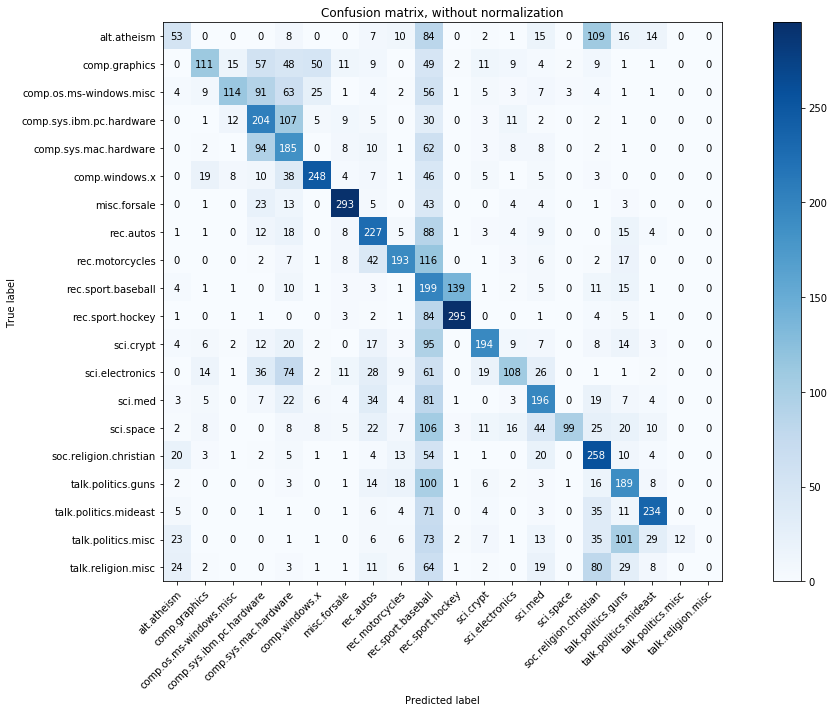

In [14]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix


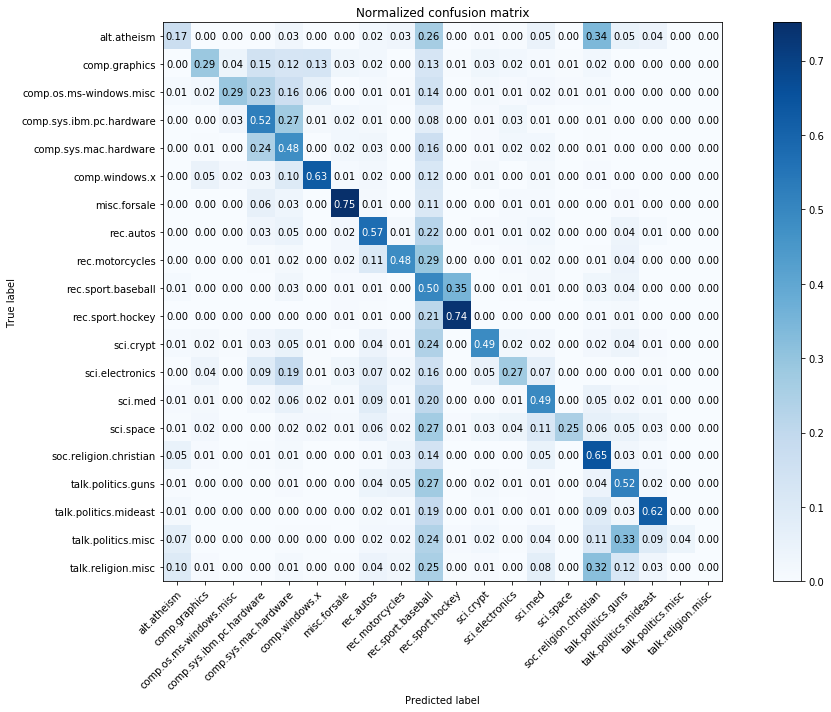

In [15]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()